## 4-1

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import torchvision.transforms as transforms
from torchvision.models import resnet18
import pandas as pd
import os
from PIL import Image
import cv2
import numpy as np


c:\Users\user\anaconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Custom dataset class
class MNISTDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = [f for f in os.listdir(root_dir) if f.endswith('.png')]

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.samples[idx])
        img = cv2.imread(img_name)
        
        if self.transform:
                img = self.transform(img)
        
        if self.root_dir.split('_')[2]=='train':
            
            label_file = img_name.replace('.png', '.txt')
            with open(label_file, 'r') as f:
                label = int(f.readline()[0])

            return img, label
        else:
            return img, self.samples[idx]

# Define transforms
transform = transforms.Compose([
    transforms.ToTensor(),
])


In [4]:
from sklearn.model_selection import StratifiedShuffleSplit


def create_stratified_split(dataset, test_size=0.2):
    labels = []
    for _, label_path in enumerate(dataset.samples):
        label_file = os.path.join(dataset.root_dir, label_path).replace('.png', '.txt')
        with open(label_file, 'r') as f:
            label = int(f.readline().strip()[0])
        labels.append(label)

    sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=0)
    train_idx, valid_idx = next(sss.split(np.zeros(len(labels)), labels))
    return train_idx, valid_idx

# Create dataset
train_dataset = MNISTDataset('../HW2/HW2_MNIST_train', transform=transform)

# If val_flag is true, create stratified split
val_flag = True
if val_flag:
    train_idx, valid_idx = create_stratified_split(train_dataset)

    # Create samplers
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    # Create loaders
    batch_size = 64
    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)
    valid_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=valid_sampler)
else:
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)


In [5]:
def count_classes(dataset, indices):
    class_counts = {}
    for idx in indices:
        img_name = os.path.join(dataset.root_dir, dataset.samples[idx])
        label_file = img_name.replace('.png', '.txt')
        with open(label_file, 'r') as f:
            label = int(f.readline().strip()[0])
        if label in class_counts:
            class_counts[label] += 1
        else:
            class_counts[label] = 1
    return class_counts

# Count classes in the training set
train_class_counts = count_classes(train_dataset, train_idx)
print("Training set class counts:", train_class_counts)

# Count classes in the validation set
valid_class_counts = count_classes(train_dataset, valid_idx)
print("Validation set class counts:", valid_class_counts)


Training set class counts: {6: 7579, 7: 8005, 5: 6950, 1: 8668, 2: 7625, 8: 7542, 9: 7619, 4: 7451, 0: 8628, 3: 7849}
Validation set class counts: {4: 1863, 2: 1906, 3: 1963, 5: 1737, 6: 1895, 9: 1905, 8: 1885, 0: 2157, 1: 2167, 7: 2002}


In [6]:
import torch.nn as nn
import torch.optim as optim
from datetime import datetime

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 定义RNN模型
class RNNClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, rnn_type):
        super(RNNClassifier, self).__init__()
        if rnn_type == 'SimpleRNN':
            self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        elif rnn_type == 'LSTM':
            self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        elif rnn_type == 'GRU':
            self.rnn = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # x shape: (batch, seq_len, input_size)
        out, _ = self.rnn(x)
        # 只取序列的最后一个输出
        out = out[:, -1, :]
        out = self.fc(out)
        return out

# 设定超参数
input_size = 256  # 每个图像块展平后的大小 (16x16)
hidden_size = 256  # RNN的隐藏层大小
num_layers = 4  # RNN的层数
num_classes = 10  # MNIST分类总数
seq_length = 64  # 图像转换成序列的长度 (128x128 图像分割成8x8块，每块16x16)

# 定义模型
models = {
    'SimpleRNN': RNNClassifier(input_size, hidden_size, num_layers, num_classes, 'SimpleRNN'),
    'LSTM': RNNClassifier(input_size, hidden_size, num_layers, num_classes, 'LSTM'),
    'GRU': RNNClassifier(input_size, hidden_size, num_layers, num_classes, 'GRU'),
}

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizers = {m: optim.Adam(model.parameters(), lr=0.001) for m, model in models.items()}

# 定义图像转换为序列的函数
def image_to_seq(image, block_size=16):
    # 将图像分割成小块并展平
    patches = image.unfold(2, block_size, block_size).unfold(3, block_size, block_size)
    patches = patches.contiguous().view(image.size(0), -1, block_size*block_size)
    return patches

# 训练循环
num_epochs = 15
for model_name, model in models.items():
    print(f'Start training {model_name}:')
    model = model.to(device)
    optimizer = optimizers[model_name]
    best_val_acc = 0.0
    for epoch in range(num_epochs):
        model.train()
        train_loss, train_correct, train_total = 0.0, 0, 0
        val_loss, val_correct, val_total = 0.0, 0, 0

        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            # 转换图像为序列
            images_seq = image_to_seq(images)
            
            # 前向传播
            outputs = model(images_seq)
            loss = criterion(outputs, labels)
            
            # 反向传播和优化
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # 记录训练统计
            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
        
        # 计算并打印统计
        train_acc = train_correct / train_total
        
        
        model.eval()
        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                images_seq = image_to_seq(images)
                outputs = model(images_seq)
                loss = criterion(outputs, labels)

                # 记录验证统计
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_acc = val_correct / val_total
        print(f'Epoch [{epoch+1}/{num_epochs}], {model_name} Train Loss: {train_loss / len(train_loader):.4f}, Train Accuracy: {train_acc:.4f}, Val Loss: {val_loss / len(valid_loader):.4f}, Val Accuracy: {val_acc:.4f}')
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), f'best_{model_name}.pth')
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    torch.save(model.state_dict(), f'{model_name}_{timestamp}.pth')


Using device: cuda:0
Start training SimpleRNN:
Epoch [1/15], SimpleRNN Train Loss: 2.3194, Train Accuracy: 0.1039, Val Loss: 2.3099, Val Accuracy: 0.1112
Epoch [2/15], SimpleRNN Train Loss: 2.3147, Train Accuracy: 0.1030, Val Loss: 2.3375, Val Accuracy: 0.1112
Epoch [3/15], SimpleRNN Train Loss: 2.3190, Train Accuracy: 0.1031, Val Loss: 2.3236, Val Accuracy: 0.1107
Epoch [4/15], SimpleRNN Train Loss: 2.3186, Train Accuracy: 0.1039, Val Loss: 2.3142, Val Accuracy: 0.1107
Epoch [5/15], SimpleRNN Train Loss: 2.3208, Train Accuracy: 0.1034, Val Loss: 2.3067, Val Accuracy: 0.1112
Epoch [6/15], SimpleRNN Train Loss: 2.3219, Train Accuracy: 0.1045, Val Loss: 2.3239, Val Accuracy: 0.1008
Epoch [7/15], SimpleRNN Train Loss: 2.3226, Train Accuracy: 0.1032, Val Loss: 2.3096, Val Accuracy: 0.1008
Epoch [8/15], SimpleRNN Train Loss: 2.3216, Train Accuracy: 0.1034, Val Loss: 2.3097, Val Accuracy: 0.1028
Epoch [9/15], SimpleRNN Train Loss: 2.3227, Train Accuracy: 0.1011, Val Loss: 2.3087, Val Accurac

In [7]:
# Number of layers and parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

num_parameters = count_parameters(models['SimpleRNN'])
print("Number of trainable parameters(SimpleRNN): ", num_parameters)

num_parameters = count_parameters(models['LSTM'])
print("Number of trainable parameters(LSTM): ", num_parameters)

num_parameters = count_parameters(models['GRU'])
print("Number of trainable parameters(GRU): ", num_parameters)


Number of trainable parameters(SimpleRNN):  528906
Number of trainable parameters(LSTM):  2107914
Number of trainable parameters(GRU):  1581578


In [10]:
test_dataset = MNISTDataset('../HW2/HW2_MNIST_test', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

model = RNNClassifier(input_size, hidden_size, num_layers, num_classes, 'GRU')

# load model
model_path = 'best_GRU.pth'  # 替换为您保存的模型的实际路径
model.load_state_dict(torch.load(model_path, map_location=device))
model = model.to(device)


# Perform predictions on the test set
model.eval()  # Make sure the model is in evaluation mode
predictions = []
image_files = []

with torch.no_grad():
    for data in test_loader:
        images, file_names = data
        images = images.to(device)
        images_seq = image_to_seq(images)
        outputs = model(images_seq)
        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(predicted.cpu().numpy())
        image_files.extend(file_names)

# Save to CSV
predictions_df = pd.DataFrame({
    'image': image_files,
    'class': predictions
})
predictions_df.to_csv('HW4_prob1.csv', index=False)

## 4.2

Epoch [100/1000], Loss: 0.0000
Epoch [200/1000], Loss: 0.0000
Epoch [300/1000], Loss: 0.0000
Epoch [400/1000], Loss: 0.0000
Epoch [500/1000], Loss: 0.0000
Epoch [600/1000], Loss: 0.0000
Epoch [700/1000], Loss: 0.0000
Epoch [800/1000], Loss: 0.0000
Epoch [900/1000], Loss: 0.0000
Epoch [1000/1000], Loss: 0.0000


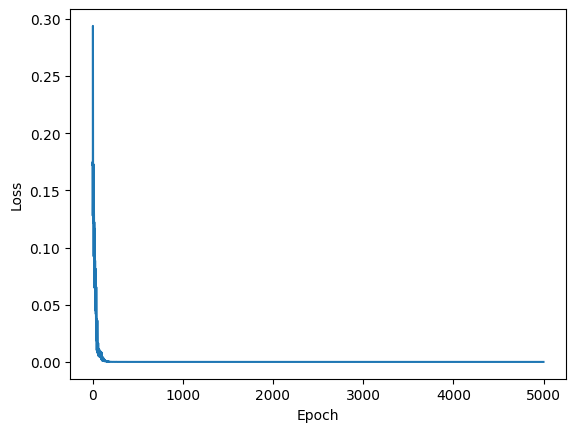

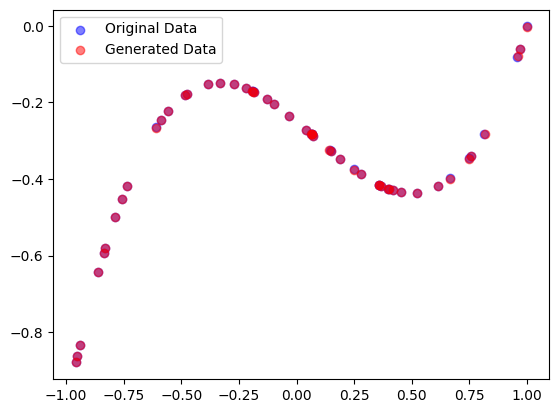

In [11]:
from torch.utils.data import TensorDataset
import matplotlib.pyplot as plt
import pandas as pd


data_path = './HW4_prob2.csv'
data = pd.read_csv(data_path)

# 准备数据
X = torch.tensor(data.values, dtype=torch.float32)

# 由于我们是在生成任务中，我们不需要标签。我们将使用数据本身作为输入和输出
dataset = TensorDataset(X, X)
data_loader = DataLoader(dataset, batch_size=10, shuffle=True)

# 定义模型
class Generator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Generator, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
        )
        
    def forward(self, x):
        return self.network(x)

# 实例化模型
input_size = X.size(1)
hidden_size = 50  # 设定隐藏层的大小
output_size = input_size  # 输出大小与输入大小相同
model = Generator(input_size, hidden_size, output_size)

# 损失函数和优化器
criterion = nn.MSELoss()  # 使用均方误差损失
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 训练模型
num_epochs = 1000  # 训练的轮数
losses = []  # 用来记录损失值
for epoch in range(num_epochs):
    for batch_features, _ in data_loader:
        # 前向传播
        batch_features = batch_features.to(torch.float32)
        outputs = model(batch_features)
        loss = criterion(outputs, batch_features)
        
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # 记录损失值
        losses.append(loss.item())
    
    # 打印训练过程中的损失值
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# 绘制损失值图表
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# 使用训练好的模型生成新的数据点
with torch.no_grad():
    new_data = model(X).numpy()

# 绘制原始数据点和生成的数据点
plt.scatter(data['U1'], data['U2'], color='blue', alpha=0.5, label='Original Data')
plt.scatter(new_data[:, 0], new_data[:, 1], color='red', alpha=0.5, label='Generated Data')
plt.legend()
plt.show()


Epoch [100/1000], Loss: 0.0002
Epoch [200/1000], Loss: 0.0000
Epoch [300/1000], Loss: 0.0000
Epoch [400/1000], Loss: 0.0000
Epoch [500/1000], Loss: 0.0000
Epoch [600/1000], Loss: 0.0000
Epoch [700/1000], Loss: 0.0000
Epoch [800/1000], Loss: 0.0000
Epoch [900/1000], Loss: 0.0000
Epoch [1000/1000], Loss: 0.0000


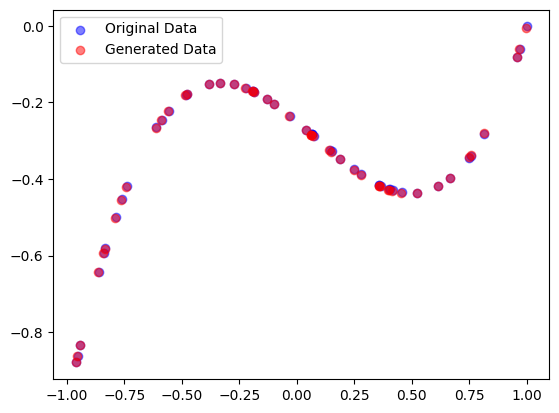

In [12]:
# 定义GRU模型
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden):
        out, hidden = self.gru(x, hidden)
        out = self.fc(out[:, -1, :])  # 只使用最后一个时间步的输出
        return out, hidden

# 实例化模型
input_size = 2  # 修改input_size为2，因为有两个特征 U1 和 U2
hidden_size = 50  # GRU的隐藏层大小
num_layers = 1  # GRU的层数
output_size = input_size  # 输出大小与输入大小相同
gru_model = GRUModel(input_size, hidden_size, num_layers, output_size).to(device)

# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = optim.Adam(gru_model.parameters(), lr=0.001)

# 修正数据的维度，确保每个时间步只有一个特征值
# 由于数据并不是时序的，我们将每个点视为独立的，没有时间依赖性
X_gru = X.unsqueeze(1)  # 增加一个时间维度

# 训练GRU模型
num_epochs = 1000
for epoch in range(num_epochs):
    hidden = None  # 初始化隐藏状态
    for batch_features, _ in data_loader:
        # 重置梯度
        optimizer.zero_grad()
        
        # 调整输入数据的形状
        batch_features = batch_features.unsqueeze(1).to(device)
        
        # 前向传播
        outputs, hidden = gru_model(batch_features, hidden)
        # 我们不希望隐藏状态被梯度下降步骤影响
        # 因此我们将其从历史中分离出来
        hidden = hidden.detach()
        
        loss = criterion(outputs, batch_features[:, -1, :])
        # 反向传播
        loss.backward()
        optimizer.step()
        
    # 每100轮输出一次损失
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# 使用训练好的GRU模型生成新的数据点
with torch.no_grad():
    # 由于我们的数据不是真正的时序数据，我们将整个数据作为一个批次进行处理
    # 这样我们就可以生成与原数据相同数量的新数据点
    X_gru = X_gru.to(device)
    generated_data, _ = gru_model(X_gru, None)
    generated_data = generated_data.cpu().numpy()

# 绘制原始数据点和生成的数据点
plt.scatter(data['U1'], data['U2'], color='blue', alpha=0.5, label='Original Data')
plt.scatter(generated_data[:, 0], generated_data[:, 1], color='red', alpha=0.5, label='Generated Data')
plt.legend()
plt.show()

